### Importing essential libraries

In [3]:
import numpy as np
import pandas as pd
import cv2
import math
import matplotlib.pyplot as plt    
# for preprocessing the images
from keras.preprocessing import image   
from keras.utils import np_utils
# for resizing images
from skimage.transform import resize  

Using TensorFlow backend.


### Step 1: Extracting the static images from the video file
We'll be using a mp4 file of duration 04:58 minutes. When converted to seconds it'll be equivalent to 298 seconds and if we constrict the frame size to 1, we will have 298 images in total.

In [0]:
count = 0
videoFile = "Tom and jerry.mp4"
videoCapture = cv2.VideoCapture(videoFile)   # capturing the video from the given path
frameRate = videoCapture.get(5) # frame rate
x=1
while(videoCapture.isOpened()):
    frameId = videoCapture.get(1) #current frame number
    ret, frame = videoCapture.read()
    if (ret != True):
        break
    if (frameId % math.floor(frameRate) == 0):
        filename ="frame%d.jpg" % count;count+=1
        cv2.imwrite(filename, frame)
videoCapture.release()

### Step- 2: Label the images to encode them according to TOM/ JERRY's presence in the pic for training.
We'll encode the images as 0 for TOM, 1 for JERRY and -1 for neither in the frames. The labelled data is stored in mapping.csv.

In [6]:
data = pd.read_csv('mapping.csv') 
data.head()

,Image_ID,Class
0,frame0.jpg,1
1,frame1.jpg,1
2,frame2.jpg,0
3,frame3.jpg,0
4,frame4.jpg,0


You can view whether the mapping is correct or not by viewing the corresponding frame.

Text(0.5, 1.0, 'label: 0')

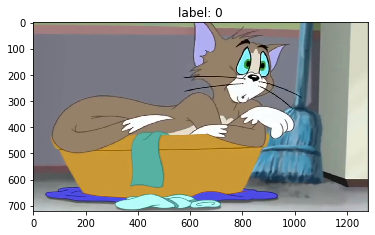

In [0]:
img = cv2.imread('frame2.jpg')
plt.imshow(img)
plt.title('label: 0') # Zero indicates TOM should be in the image

Text(0.5, 1.0, 'label: 1')

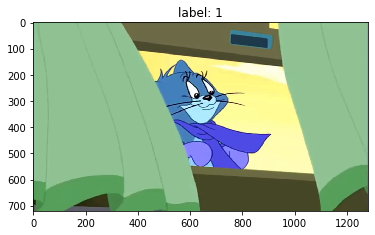

In [0]:
img = cv2.imread('frame0.jpg')
plt.imshow(img)
plt.title('label: 1') # Zero indicates TOM should be in the imagee

### Step 3: Convert and stack the images as numpy arrays
For input to the neural nets, we convert the '.jpg' images to numpy arrays and one- hot encoding the classes. Further we reduce the size of images so as to have their size equivalent to the one we are supposed to provide as input to the pretrained networks.

In [0]:
images = []
for image in data.Image_ID:
    img = cv2.imread(image)
    X = np.array(img)
    images.append(X)
images = np.array(images)

In [0]:
# one hot encoding Classes
y = np_utils.to_categorical(data.Class, num_classes = 3)    

Pretrained models are a wonderful source of help for people looking to learn an algorithm or try out an existing framework. Due to time restrictions or computational restraints, it’s not always possible to build a model from scratch which is why pretrained models exist! You can use a pretrained model as a benchmark to either improve the existing model, or test your own model against it. The potential and possibilities are vast.

In [0]:
# Reducing the size of images to 224*224*3
img = []
for i in range(0,images.shape[0]):
    a = resize(images[i], preserve_range=True, output_shape=(224,224)).astype(int)      
    img.append(a)
X = np.array(img)

In [0]:
from keras.applications.vgg16 import preprocess_input
X = preprocess_input(X, mode='tf')      # preprocessing the input data

### Step 5: Creating training, validation and test sets.
We also need a validation set to check the performance of the model on unseen images. We will make use of the train_test_split() function of the sklearn.model_selection module to randomly divide images into training and validation set.

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.3, random_state=42)

(208, 224, 224, 3)

### Step 6: Building the models
We will be using the predictions from the pretrained VGG16 model as input to the base CNN which we'll develop later

In [0]:
from keras.models import Sequential
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, InputLayer, Dropout

#### VGG16 model for prediction over Training and Validation sets

In [0]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))    

In [0]:
X_train = base_model.predict(X_train)
X_eval = base_model.predict(X_eval)


In [23]:
# The shapes of output are (208,7,7,512)
X_train.shape, X_eval.shape

((208, 7, 7, 512), (90, 7, 7, 512))

In [0]:
# Reshaping to 1-D array
X_train = X_train.reshape(208, -1)      
X_eval = X_eval.reshape(90,-1)

In [0]:
# Centering the data
train = X_train/X_train.max()     
X_eval = X_eval/X_train.max()

#### Training the base CNN

In [35]:
net = Sequential()
net.add(InputLayer((7*7*512,)))    # input layer
net.add(Dense(units=1024, activation='sigmoid')) # hidden layer
net.add(Dense(3, activation='softmax'))    # output layer
net.summary()
# O/P has 3 neurons because we've 3 classes to predict

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 3075      
Total params: 25,694,211
Trainable params: 25,694,211
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Setting the optimizer, type of loss and metric for assessment of the model
net.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [43]:
# Training the model
net.fit(train, y_train, epochs=200, validation_data=(X_eval, y_eval))

Train on 208 samples, validate on 90 samples
Epoch 1/200
208/208 [==============================] - 0s 860us/step - loss: 0.0070 - acc: 0.9952 - val_loss: 0.7095 - val_acc: 0.7111
Epoch 2/200
208/208 [==============================] - 0s 818us/step - loss: 0.0070 - acc: 0.9952 - val_loss: 0.6899 - val_acc: 0.7778
Epoch 3/200
208/208 [==============================] - 0s 817us/step - loss: 0.0068 - acc: 0.9952 - val_loss: 0.6847 - val_acc: 0.8444
Epoch 4/200
208/208 [==============================] - 0s 796us/step - loss: 0.0075 - acc: 0.9904 - val_loss: 0.6666 - val_acc: 0.8778
Epoch 5/200
208/208 [==============================] - 0s 792us/step - loss: 0.0076 - acc: 0.9904 - val_loss: 0.7077 - val_acc: 0.7222
Epoch 6/200
208/208 [==============================] - 0s 795us/step - loss: 0.0070 - acc: 0.9952 - val_loss: 0.7058 - val_acc: 0.7333
Epoch 7/200
208/208 [==============================] - 0s 781us/step - loss: 0.0072 - acc: 0.9952 - val_loss: 0.7117 - val_acc: 0.7111
Epoch 8/20

At the end of 200 epochs we could acheive a validation accuracy of 85.66%

### Step 7: EVALUATING THE MODEL OVER TEST DATA
For this phase, we once again will extract the frames and preprocess the images obtained from the test .mp4 file before we evaluate it using the net. We have a subpar performance on the test set (probably due to the lack of training data)

In [0]:
# Similar to earlier extract the preprocess the video file and corresponding images
count = 0
videoFile = "Tom and Jerry 2.mp4"
cap = cv2.VideoCapture(videoFile)
frameRate = cap.get(5) #frame rate
x=1
while(cap.isOpened()):
    frameId = cap.get(1) #current frame number
    ret, frame = cap.read()
    if (ret != True):
        break
    if (frameId % math.floor(frameRate) == 0):
        filename ="test%d.jpg" % count;count+=1
        cv2.imwrite(filename, frame)
cap.release()


In [55]:
test = pd.read_csv('test.csv')
test.head()

,Image_ID
0,test0.jpg
1,test1.jpg
2,test2.jpg
3,test3.jpg
4,test4.jpg


In [0]:
test_images = []
for img_name in test.Image_ID:
    img = plt.imread('' + img_name)
    test_images.append(img)
test_images = np.array(test_images)

test_img = []
for i in range(0,test_images.shape[0]):
    a = resize(test_images[i], preserve_range=True, output_shape=(224,224)).astype(int)
    test_img.append(a)
test_img = np.array(test_img)

In [0]:
# preprocessing the images
test_img = preprocess_input(test_img, mode='tf')

# extracting features from the images using VGG16
test_img = base_model.predict(test_img)

# converting the images to 1-D array
test_img = test_img.reshape(186, -1)

# zero centered images
test_img = test_img/test_img.max()

In [0]:
test_preds= net.predict_classes(test_img)

In [61]:
print("The screen time of JERRY is ", test_preds[test_preds==1].shape[0], "seconds")
print("The screen time of TOM is ", test_preds[test_preds==0].shape[0], "seconds")

The screen time of JERRY is 5 seconds
The screen time of TOM is 116 seconds
